In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/{"Exam"}

Mounted at /content/drive
/content/drive/MyDrive/Exam


Mini Batch SGD for Single Layer NN from scratch, including function approximation check

In [ ]:
#Import Relevant Packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import h5py
from tqdm import tqdm
from random import randint

In [ ]:
#Load the MNST dataset from .hd5 file in current directory

MNIST_data = h5py.File('./MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:] )
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32( MNIST_data['x_test'][:] )
y_test = np.int32( np.array( MNIST_data['y_test'][:,0]))

MNIST_data.close()

In [ ]:

class Network:
    def __init__(self, num_inputs, num_outputs, num_hidden_units, dropout_rate):
        self.dropout_rate = dropout_rate
        self.num_inputs = num_inputs
        self.num_hidden_units = num_hidden_units
        self.num_outputs = num_outputs

        # Xavier initialization for weights
        self.W1 = np.random.randn(num_hidden_units, num_inputs) * np.sqrt(2. / (num_inputs + num_hidden_units))
        self.b1 = np.zeros(num_hidden_units)
        self.W2 = np.random.randn(num_outputs, num_hidden_units) * np.sqrt(2. / (num_hidden_units + num_outputs))
        self.b2 = np.zeros(num_outputs)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax_function(self, z):
      if z.ndim == 1:
        print(' 1 sample taken')
        #  single sample is provided
        z = z.reshape(1, -1)
      exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
      return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def sigmoidgrad(self, z):
        sigmoid = self.sigmoid(z)
        return sigmoid * (1 - sigmoid)

    def mask(self, shape):
        return np.random.binomial(1, 1 - self.dropout_rate, size=shape)

    def forward(self, x,dropout_rate=None): #add dropout variable for test set
        if dropout_rate is None:
          dropout_rate=self.dropout_rate
        Z1 = np.dot(x, self.W1.T) + self.b1
        #print('Z1 SHAPE IS ' + str(Z1.shape))
        A = self.sigmoid(Z1)
        #print('A SHAPE IS ' + str(A.shape))
        dropout_mask = self.mask(A.shape)
        A *= dropout_mask / (1 - dropout_rate)  # dropout mask and scaling with delta1 to maintain expectation. delta 1 slighlty increased by the scaling to match expectation during training.
        #A = A.reshape(1, -1) if A.ndim == 1 else A

        Z2 = np.dot(A, self.W2.T) + self.b2
        p = self.softmax_function(Z2)

        A_grad = self.sigmoidgrad(Z1)
        A_grad *= dropout_mask / (1 - self.dropout_rate)

        return p, A, A_grad, dropout_mask

    def backward(self, x, y, dropout_rate=self.dropout_rate): #happens only during trianing so no need to account for test scenario.
      #print(y)
      # Supposing that y is a batch of class indices with shape batch_sizex1 .
      y_one_hot = np.zeros((x.shape[0], self.num_outputs))
      y_one_hot[np.arange(x.shape[0]), y] = 1

      p, A, A_grad, dropout_mask = self.forward(x,dropout_rate)

      # error at output
      delta2 = p - y_one_hot #batch_size x num_output

      # gradient for W2 num_outputs x num_hidden_units
      W2_grad = np.dot(delta2.T, A)

      # gradient for b2 num_outputsx1
      b2_grad = np.sum(delta2, axis=0) #summing because of batches now

      # hidden layer
      delta1 = np.dot(delta2, self.W2) * A_grad


      delta1 *= dropout_mask / (1 - dropout_rate) #mask is 1 if dropout is 0

      #  num_hidden_units x num_inputs

      W1_grad = np.dot(delta1.T, x) #not summing because this is a dot product that calculates the weight gradients for the entire batch simultaneously(matrix multiplication over batch size)

      #however the bias grads need to be explicitly summed, theoretically because biases are not related with the input of the previous layer like weights
      # gradient for b1 (num_hidden_units,)
      b1_grad = np.sum(delta1, axis=0) #summing because this is the batch update

      return W1_grad, W2_grad, b1_grad, b2_grad


    def train(self, x_train, y_train, x_test, y_test, LR=0.05, num_epochs=1, batch_size=100):
      train_accuracies=[]
      test_accuracies=[]
      time1=time.time()
      for epoch in range(num_epochs):
          # shuffle the training data
          indices = np.arange(len(x_train))
          np.random.shuffle(indices)
          x_train_shuffled = x_train[indices]
          y_train_shuffled = y_train[indices]

          for n in range(0, len(x_train), batch_size):
              x_batch = x_train_shuffled[n:n+batch_size]
              y_batch = y_train_shuffled[n:n+batch_size]

              #forward and backward pass for each batch
              W1_grad_batch, W2_grad_batch, b1_grad_batch, b2_grad_batch = self.backward(x_batch, y_batch)

              #update weights and biases
              self.W1 -= LR * W1_grad_batch
              self.W2 -= LR * W2_grad_batch
              self.b1 -= LR * b1_grad_batch
              self.b2 -= LR * b2_grad_batch
              #track accuracy every 1000 batches
              if (n // batch_size) % 1000 == 0 or n + batch_size >= len(x_train):
                    p, _, _, _ = self.forward(x_train_shuffled, dropout_rate=0)  # Use 0 dropout rate for evaluation
                    y_pred = np.argmax(p, axis=1)
                    total_correct = np.sum(y_pred == y_train_shuffled)
                    print(f"Batch {n // batch_size}, Train accuracy: {total_correct / len(x_train)}")


          # training set
          p_train, _, _, _ = self.forward(x_train_shuffled, dropout_rate=0)
          y_pred_train = np.argmax(p_train, axis=1)
          train_accuracy = np.sum(y_pred_train == y_train_shuffled) / len(x_train)
          train_accuracies.append(train_accuracy)

          # test set
          p_test, _, _, _ = self.forward(x_test, dropout_rate=0)
          y_pred_test = np.argmax(p_test, axis=1)
          test_accuracy = np.sum(y_pred_test == y_test) / len(x_test)
          test_accuracies.append(test_accuracy)
      # plotting the training and test accuracies
      plt.figure(figsize=(10, 5))
      plt.plot(train_accuracies, label='Train Accuracy BGD', color='red')
      plt.plot(test_accuracies, label='Test Accuracy BGD', color='green')
      plt.title('Train vs Test Accuracy BGD')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()
      time2 = time.time()
      print(f"Training time: {time2-time1}s.")
      print(test_accuracies[-1])

      return train_accuracies,test_accuracies


    def train_rmsprop(self, x_train, y_train,x_test,y_test, num_epochs=10, batch_size=32, learning_rate=0.001, rho=0.9, epsilon=1e-8):
        train_accuracies=[]
        test_accuracies=[]

        # running averages for rms
        r_W1 = np.zeros_like(self.W1)
        r_W2 = np.zeros_like(self.W2)
        r_b1 = np.zeros_like(self.b1)
        r_b2 = np.zeros_like(self.b2)

        time1 = time.time()  # Start time for training

        for epoch in range(num_epochs):
            # shuffle the training data
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            for n in tqdm(range(0, len(x_train), batch_size)):
                x_batch = x_train_shuffled[n:n+batch_size]
                y_batch = y_train_shuffled[n:n+batch_size]

                # forward and backward pass for each batch
                # unlike the bgd, gradients are accumulated within the `backward` method
                W1_grad, W2_grad, b1_grad, b2_grad = self.backward(x_batch, y_batch)

                # UPDATE running averages of squared gradients
                r_W1 = rho * r_W1 + (1 - rho) * W1_grad**2
                r_W2 = rho * r_W2 + (1 - rho) * W2_grad**2
                r_b1 = rho * r_b1 + (1 - rho) * b1_grad**2
                r_b2 = rho * r_b2 + (1 - rho) * b2_grad**2

                # step
                self.W1 -= (learning_rate / np.sqrt(r_W1 + epsilon)) * W1_grad
                self.W2 -= (learning_rate / np.sqrt(r_W2 + epsilon)) * W2_grad
                self.b1 -= (learning_rate / np.sqrt(r_b1 + epsilon)) * b1_grad
                self.b2 -= (learning_rate / np.sqrt(r_b2 + epsilon)) * b2_grad

                # track accuracy every 1000 batches or at the end of each epoch
                if (n // batch_size) % 1000 == 0 or n + batch_size >= len(x_train):
                    p, _, _, _ = self.forward(x_train_shuffled, dropout_rate=0)  # Use 0 dropout rate for evaluation
                    y_pred = np.argmax(p, axis=1)
                    total_correct = np.sum(y_pred == y_train_shuffled)
                    print(f"Batch {n // batch_size}, Train accuracy: {total_correct / len(x_train)}")


            #training set
            p_train, _, _, _ = self.forward(x_train_shuffled, dropout_rate=0)
            y_pred_train = np.argmax(p_train, axis=1)
            train_accuracy = np.sum(y_pred_train == y_train_shuffled) / len(x_train)
            train_accuracies.append(train_accuracy)

            # test set
            p_test, _, _, _ = self.forward(x_test, dropout_rate=0)
            y_pred_test = np.argmax(p_test, axis=1)
            test_accuracy = np.sum(y_pred_test == y_test) / len(x_test)
            test_accuracies.append(test_accuracy)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(train_accuracies, label='Train Accuracy RMS', color='orange')
        plt.plot(test_accuracies, label='Test Accuracy RMS ', color='purple')
        plt.title('Train vs Test Accuracy RMS')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        time2 = time.time()
        print(f"Training time: {time2 - time1}s.")

        return train_accuracies,test_accuracies




In [ ]:

network = Network(num_inputs=784, num_outputs=10, num_hidden_units=200, dropout_rate=0.0)
network_new = Network(num_inputs=784, num_outputs=10, num_hidden_units=200, dropout_rate=0.0)

# Initialize the new network with the same parameters as the original network
network_new.W1 = network.W1.copy()
network_new.W2 = network.W2.copy()
network_new.b1 = network.b1.copy()
network_new.b2 = network.b2.copy()

batch_size = 100  # example batch size, lets make it the same as the one we will use in training

# Generate a batch of data
sample_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
x_batch = x_train[sample_indices]
y_batch = y_train[sample_indices]

# perturb one of the biases for the entire batch
k = randint(0, network.num_hidden_units - 1)
epsilon = 1e-9
network_new.b1[k] += epsilon

#forward pass for both networks
p_new, _, _, _ = network_new.forward(x_batch)
p_old, _, _, _ = network.forward(x_batch)

# differential for whole batch
differential_batch = (np.log(p_new[np.arange(batch_size), y_batch]) -
                      np.log(p_old[np.arange(batch_size), y_batch])) / epsilon  #This is a forward euler approximation
differential = np.mean(differential_batch)

# back prop to get gradients for the original network
_, _, b1_grad, _ = network.backward(x_batch, y_batch)
print(f"Absolute error of the derivative for the perturbed unit is {np.abs(differential - b1_grad[k]) / batch_size}")


Absolute error of the derivative for the perturbed unit is 0.008667711911150436


  1%|▏         | 28/1875 [00:01<01:08, 26.92it/s]

Batch 0, Train accuracy: 0.11511666666666667


 54%|█████▍    | 1011/1875 [00:06<00:18, 46.21it/s]

Batch 1000, Train accuracy: 0.9057833333333334


100%|██████████| 1875/1875 [00:11<00:00, 163.40it/s]

Batch 1874, Train accuracy: 0.9246333333333333



  2%|▏         | 32/1875 [00:01<01:00, 30.66it/s]

Batch 0, Train accuracy: 0.9259666666666667


 55%|█████▍    | 1022/1875 [00:06<00:18, 45.35it/s]

Batch 1000, Train accuracy: 0.9393166666666667


100%|██████████| 1875/1875 [00:11<00:00, 160.69it/s]

Batch 1874, Train accuracy: 0.9440833333333334



  2%|▏         | 31/1875 [00:01<01:02, 29.45it/s]

Batch 0, Train accuracy: 0.9443333333333334


 55%|█████▌    | 1033/1875 [00:07<00:12, 65.13it/s]

Batch 1000, Train accuracy: 0.9525833333333333


100%|██████████| 1875/1875 [00:11<00:00, 157.01it/s]

Batch 1874, Train accuracy: 0.9554833333333334



  1%|▏         | 25/1875 [00:01<01:17, 23.81it/s]

Batch 0, Train accuracy: 0.9563666666666667


 55%|█████▌    | 1039/1875 [00:07<00:13, 59.83it/s]

Batch 1000, Train accuracy: 0.9600166666666666


100%|██████████| 1875/1875 [00:11<00:00, 162.97it/s]

Batch 1874, Train accuracy: 0.9634833333333334



  2%|▏         | 29/1875 [00:01<01:06, 27.72it/s]

Batch 0, Train accuracy: 0.9625333333333334


 54%|█████▍    | 1010/1875 [00:06<00:19, 43.61it/s]

Batch 1000, Train accuracy: 0.9665


100%|██████████| 1875/1875 [00:11<00:00, 162.63it/s]

Batch 1874, Train accuracy: 0.9658666666666667



  2%|▏         | 32/1875 [00:01<01:00, 30.45it/s]

Batch 0, Train accuracy: 0.9669666666666666


 54%|█████▍    | 1014/1875 [00:06<00:20, 42.41it/s]

Batch 1000, Train accuracy: 0.9692666666666667


100%|██████████| 1875/1875 [00:11<00:00, 160.67it/s]

Batch 1874, Train accuracy: 0.9690666666666666



  2%|▏         | 29/1875 [00:01<01:06, 27.78it/s]

Batch 0, Train accuracy: 0.9692166666666666


 54%|█████▍    | 1020/1875 [00:06<00:15, 55.54it/s]

Batch 1000, Train accuracy: 0.9721666666666666


100%|██████████| 1875/1875 [00:11<00:00, 163.81it/s]

Batch 1874, Train accuracy: 0.9732833333333333



  2%|▏         | 34/1875 [00:01<00:55, 32.91it/s]

Batch 0, Train accuracy: 0.9729166666666667


 55%|█████▍    | 1025/1875 [00:06<00:17, 48.21it/s]

Batch 1000, Train accuracy: 0.9736666666666667


100%|██████████| 1875/1875 [00:11<00:00, 163.97it/s]

Batch 1874, Train accuracy: 0.9741166666666666



  2%|▏         | 29/1875 [00:01<01:06, 27.92it/s]

Batch 0, Train accuracy: 0.9747666666666667


 55%|█████▍    | 1028/1875 [00:06<00:13, 63.10it/s]

Batch 1000, Train accuracy: 0.9756666666666667


100%|██████████| 1875/1875 [00:11<00:00, 168.90it/s]

Batch 1874, Train accuracy: 0.97705



  1%|          | 23/1875 [00:01<01:24, 21.92it/s]

Batch 0, Train accuracy: 0.9770666666666666


 55%|█████▍    | 1026/1875 [00:06<00:14, 58.64it/s]

Batch 1000, Train accuracy: 0.9778166666666667


100%|██████████| 1875/1875 [00:11<00:00, 161.26it/s]

Batch 1874, Train accuracy: 0.9773333333333334


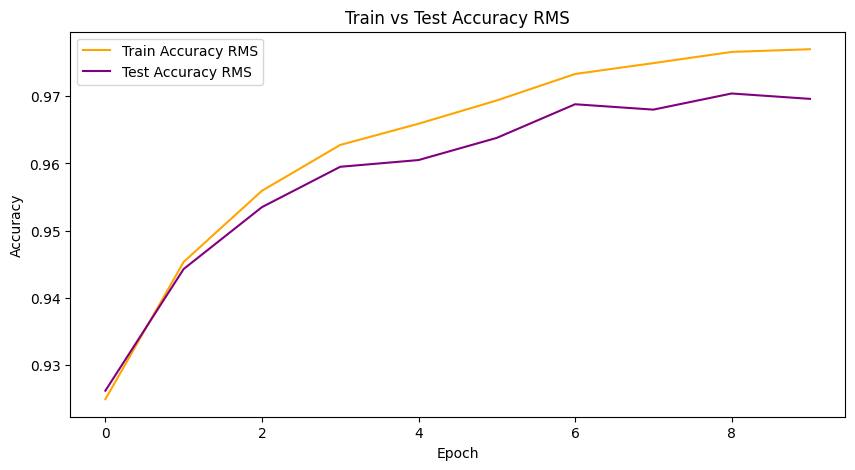

Training time: 132.22641730308533s.


([0.9249333333333334,
  0.94535,
  0.9559333333333333,
  0.96275,
  0.9659,
  0.9693666666666667,
  0.9733,
  0.9749166666666667,
  0.9765833333333334,
  0.9769833333333333],
 [0.9262,
  0.9443,
  0.9535,
  0.9595,
  0.9605,
  0.9638,
  0.9688,
  0.968,
  0.9704,
  0.9696])

In [ ]:
#RMS PROP TRAIN - CPU, 51 GB RAM
# default specs used: num_epochs=10, batch_size=32, learning_rate=0.001, rho=0.9, epsilon=1e-8
networkr = Network(num_inputs=784, num_outputs=10, num_hidden_units=200, dropout_rate=0.25)
networkr.train_rmsprop(x_train, y_train,x_test,y_test)


Batch 0, Train accuracy: 0.10218333333333333
Batch 599, Train accuracy: 0.89865
Batch 0, Train accuracy: 0.9069666666666667
Batch 599, Train accuracy: 0.9188833333333334
Batch 0, Train accuracy: 0.9125666666666666
Batch 599, Train accuracy: 0.9289166666666666
Batch 0, Train accuracy: 0.9289333333333334
Batch 599, Train accuracy: 0.9389833333333333
Batch 0, Train accuracy: 0.93905
Batch 599, Train accuracy: 0.9430833333333334
Batch 0, Train accuracy: 0.9406666666666667
Batch 599, Train accuracy: 0.94835
Batch 0, Train accuracy: 0.9478833333333333
Batch 599, Train accuracy: 0.9463333333333334
Batch 0, Train accuracy: 0.9478166666666666
Batch 599, Train accuracy: 0.9516
Batch 0, Train accuracy: 0.9534833333333333
Batch 599, Train accuracy: 0.9563
Batch 0, Train accuracy: 0.9575666666666667
Batch 599, Train accuracy: 0.95195
Batch 0, Train accuracy: 0.9521333333333334
Batch 599, Train accuracy: 0.9610166666666666
Batch 0, Train accuracy: 0.9604833333333334
Batch 599, Train accuracy: 0.9540

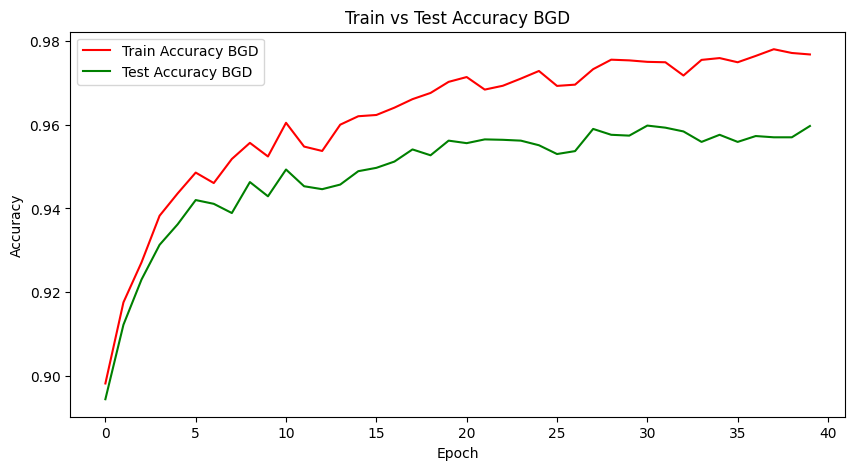

Training time: 295.13684129714966s.
0.9597


In [ ]:
#BATCH GRAD DESCENT - CPU, 51 GB RAM

network = Network(num_inputs=784, num_outputs=10, num_hidden_units=200, dropout_rate=0.22) #tested multiple LR and dropout rates for better accuracy
network = network.train(x_train, y_train,x_test,y_test, LR=0.04,num_epochs=40, batch_size=100)
